# Normalizing Flows - Affine Coupling with CNNs

This codebook is a minimal example of the implementation of a normalizing flow composed of affine coupling layers only, which are based on 2D input (hence, small CNNs are used).

## Imports

We use numpy to generate artificial data. Torch for our model.

In [15]:
%matplotlib inline
import numpy as np


import matplotlib.pyplot as plt
%pylab inline

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.distributions.normal import Normal

Populating the interactive namespace from numpy and matplotlib


## Data

We create arbitrary data (grid patterns) of a dimensionality of our preference (2-dimensional).

In [3]:
class TensorDataset(Dataset):
    def __init__(self, tensor):
        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        return self.tensor[idx]

In [104]:
# Define data parameters (dimensionality and number of samples)
c, h, w = 1, 40, 40
n_samples = 100
batch_size = 8

MASK = np.array([[[1 if (i+j) %2 == 0 else 0 for i in range(w)] for j in range(h)] for _ in range(c)])
MASK_TENSOR = torch.tensor(MASK)

# Create an artificial dataset
dataset = TensorDataset(
    torch.tensor(np.array([
        MASK * 10 + np.random.rand(h, w) - 0.5
        for _ in range(n_samples)
    ])).float() 
)
loader = DataLoader(dataset, batch_size=batch_size)

### Showing some datapoints

We visualize some data points to see what our dataset looks like.

<Figure size 432x288 with 0 Axes>

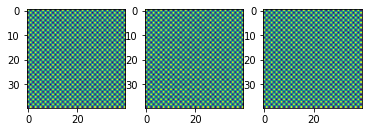

In [105]:
plt.figure()
_, axarr = plt.subplots(1, 3)

for i in range(3):
  axarr[i].imshow(dataset[i][0].numpy())

plt.show()

## Model

We implement the AffineCoupling layer first. This affine coupling layer is going to use a small CNN to obtain scale and translation.

To split the input into two equally-sized halves, we use a chessboard-like pattern (mask).

The FlowModel is just going to be a sequential execution of such layers, with alternating masks.

In [106]:
class AffineCoupling(nn.Module):
    def __init__(self, mask):
        super(AffineCoupling, self).__init__()
        self.mask = mask
        self.network = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=1),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 2, 3, padding=1),
        )

    def forward(self, x):
        x1 = x * self.mask
        st = self.network(x1)
        s, t = st.chunk(2, 1)

        s = (1 - self.mask) * torch.sigmoid(s + 2)
        t = (1 - self.mask) * t

        out = x1 + (x * s + t)
        log_det = torch.sum(torch.log(s + self.mask), dim=[1, 2, 3]) # Add the mask to not obtain negative infinity

        return out, log_det

    def backward(self, out):
        x1 = self.mask * out
        x2 = out - x1

        st = (1 - self.mask) * self.network(x1)
        s, t = st.chunk(2, 1)
        s = torch.sigmoid(s + 2)

        x2 = (x2 - t) / s

        return x1 + x2

    def zero_init(self):
      for param in self.parameters():
        param.data.zero_()

In [107]:
class FlowModel(nn.Module):
    def __init__(self, in_dim, n_steps):
        super(FlowModel, self).__init__()
        self.in_dim = in_dim
        self.n_steps = n_steps

        # Create a ModuleList of affine coupling layers with alternating masks
        self.layers = nn.ModuleList([
            AffineCoupling(MASK_TENSOR if i % 2 == 0 else 1 - MASK_TENSOR)
            for i in range(n_steps)
        ])

        # Initialize all parameters to 0 for training stability
        for layer in self.layers:
          layer.zero_init()

    def forward(self, x):
        # Running input through all affine coupling layers
        out, total_log_det = x, 0.0
        for layer in self.layers:
            out, log_det = layer(out)
            total_log_det += log_det
        return out, total_log_det

    def backward(self, out):
        # Running backward through all layers starting from the last
        x = out
        n = len(self.layers)
        for i in range(len(self.layers)):
            x = self.layers[n - 1 - i].backward(x)
        return x

# Main program

We train two models on our arbitrary data. The models differ in that one uses the sigmoid activation trick, and the second doesn't. We compare their training curves. 

We then just keep the model that uses the sigmoid trick and check that samples are mapped to a normal distribution. Also, we check that the function is invertible.

**Optional: ** Try to keep the model that doesn't use the sigmoid trick for the next cells, and check the likelihood of the latent distribution.

	Epoch 1 loss: 2693.81
	Epoch 20 loss: 991.32
	Epoch 40 loss: 371.49
	Epoch 60 loss: 112.74
	Epoch 80 loss: 51.66
	Epoch 100 loss: 33.22
	Epoch 120 loss: 24.48
	Epoch 140 loss: 19.42
	Epoch 160 loss: 16.17
	Epoch 180 loss: 13.93
	Epoch 200 loss: 12.32


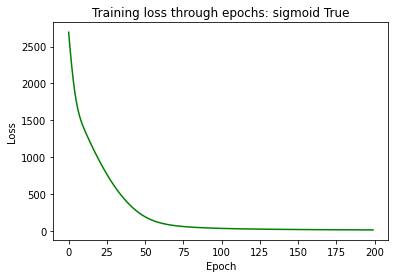

In [108]:
# Parameters
n_steps = 4
n_epochs = 200
print_freq = n_epochs // 10
lr = 0.01

# Model and optimizer
model = FlowModel(c, n_steps)
optim = Adam(model.parameters(), lr=lr)

# Plotting variable
losses = []

# Training loop
model.train()
in_dimension = c * h * w
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x in loader:
        out, log_det = model(x)

        # The loss is the log likelihood for a normal distribution minus the log_det
        pz = torch.sum(out**2 / in_dimension**0.5, dim=[1, 2, 3])
        loss = torch.mean(pz - log_det)
        epoch_loss += loss.item() / len(x)

        optim.zero_grad()
        loss.backward()
        optim.step()

    losses.append(epoch_loss)
    if (epoch + 1) % print_freq == 0 or epoch == 0:
        print(
            f"\tEpoch {epoch + 1} loss: {epoch_loss:.2f}"
        )

start = 0

# Plotting training curve
plt.plot(np.arange(len(losses[start:])), losses[start:], "g-", label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training loss through epochs: sigmoid {sigmoid}")
plt.show()

## Testing invertibility

We test the invertibility by checking the MSE between the input and the re-construction.

In [111]:
with torch.no_grad():
    x = dataset.tensor
    out, _ = model(x)
    reconstructed = model.backward(out)

mse = torch.mean((x - reconstructed) ** 2)
print(f"Mean squared error between original and reconstruction: {mse.item():.9f}")

Mean squared error between original and reconstruction: 0.000000000


## Tesing mapping to a normal

We test that the input was mapped to a normal distribution with mean 0 and std 1 by checking the mean probability.

In [115]:
normal = Normal(0, 1)

probs = torch.exp(normal.log_prob(out))
mean_prob = torch.mean(probs).item()
min_prob = torch.min(probs).item()

p_0 = torch.exp(normal.log_prob(torch.tensor([0]))).item()

print(f"Mean probability Pz is: {mean_prob:.3f} (minimum is {min_prob:.3f})")
print(f"Probability for x=0 (normal distribution): {p_0:.3f}")

Mean probability Pz is: 0.383 (minimum is 0.351)
Probability for x=0 (normal distribution): 0.399


# Conclusion

With this notebook, we learned how to implement (from scratch) a normalizing flow composed of affine coupling layers only. The flow implements an invertible function which can map an input to a desired prior distribution. In this example, such distribution is a gaussian with mean 0 and standard deviation 1.



<center><h2>Credits</h2></center>

**Brian Pulfer** ([Website](https://www.brianpulfer.ch), [Twitter](https://twitter.com/PulferBrian21), [GitHub](https://github.com/BrianPulfer), [LinekdIn](https://www.linkedin.com/in/BrianPulfer/))<br/>
University of Geneva <br/>
27.04.2022